In [1]:
import os
import time
import numpy
import paddle
from PIL import Image
import paddle.fluid as fluid
import matplotlib.pyplot as plt

## Network models

### fc-sotfmax model

In [2]:
def softmax_regression():
    """
    softmax classifier：
        a fully connected layer with the softmax activation function
    Return:
        predicted image
    """
    # the size of MNIST handwritten images: 28*28*1 (1 channel)
    # None is equal to -1 representing the unknown size
    #     which will be changed based on the input data
    img = fluid.data(name='img', shape=[None, 1, 28, 28], dtype='float32')

    # Activation function: relu, sigmoid and tanh
    # Note: softmax isn't an activation function (for paddle, not for tensorflow)
    predict = fluid.layers.fc(input=img, size=10, act='softmax') # total 10 digits: 0-9
    return predict

### Multilayer Perceptron (MLP)

In [3]:
def multilayer_perceptron():
    """
    The Multilayer Perceptron which contains two hidden layers (fully connected layer)
    
    The first two hidden layers use ReLU while the output layer uses Softmax

    Return:
        predicted image
    """
    # input image
    img = fluid.data(name='img', shape=[None, 1, 28, 28], dtype='float32')

    # the first fulled connected layer
    hidden = fluid.layers.fc(input=img, size=200, act='relu') # 200 Neurons = 200 equations

    # the second fulled connected layer
    hidden = fluid.layers.fc(input=hidden, size=200, act='relu')

    # output layer using softmax as the activation function
    prediction = fluid.layers.fc(input=hidden, size=10, act='softmax')
    return prediction

### Convection and Pooling

In [4]:
def conv_pool(input, num_filters, filter_size, pool_size, pool_stride, act="relu"):
    conv_out = fluid.layers.conv2d(
        input=input,
        num_filters=num_filters,
        filter_size=filter_size,
        act=act)
    out = fluid.layers.pool2d(
        input=conv_out,
        pool_size=pool_size,
        pool_stride=pool_stride)
    return out

def convolutional_neural_network():
    img = fluid.data(name='img', shape=[None, 1, 28, 28], dtype='float32')
    # the first convolution-pooling layer
    conv_pool_1 = conv_pool(
        input=img,
        filter_size=5,
        num_filters=20,
        pool_size=2,
        pool_stride=2,
        act="relu")
    conv_pool_1 = fluid.layers.batch_norm(conv_pool_1)
    # the second layer
    conv_pool_2 = conv_pool(
        input=conv_pool_1,
        filter_size=5,
        num_filters=50,
        pool_size=2,
        pool_stride=2,
        act="relu")
    # the output layer
    prediction = fluid.layers.fc(input=conv_pool_2, size=10, act='softmax')
    return prediction

## Train program

In [5]:
def train_program():
    """
    Return:
        predict -- the result of classification
        avg_cost -- mean loss
        acc -- the accuracy of classification

    """
    # label: the actual label of input image
    label = fluid.data(name='label', shape=[None, 1], dtype='int64')

    # prediction (uncomment to use the specific model, default: convolutional_neural_network)
#     predict = softmax_regression()
#     predict = multilayer_perceptron()
    predict = convolutional_neural_network()

    # use Cross Entropy to calculate the loss function between "predict" and "label"
    cost = fluid.layers.cross_entropy(input=predict, label=label)
    # mean loss
    avg_cost = fluid.layers.mean(cost)
    # the accuracy of classification
    acc = fluid.layers.accuracy(input=predict, label=label)
    return predict, [avg_cost, acc]

## Optimizer

In [6]:
def optimizer_program():
    # Stochastic gradient descent (SGD), Adam is better than the basic SGD
    return fluid.optimizer.Adam(learning_rate=0.001)

## Feeders

In [7]:
# each batch has 128 samples
BATCH_SIZE = 128

# Shuffle 500 data from the Training sets every time
#     and pass them to batched reader which yields 128 data every time
train_reader = fluid.io.batch(paddle.reader.shuffle(paddle.dataset.mnist.train(), buf_size=500),
                              batch_size=BATCH_SIZE)  # return 128 data

# Read 64 data from the Test sets
test_reader = fluid.io.batch(paddle.dataset.mnist.test(), batch_size=BATCH_SIZE*10)

## Visialization

In [8]:
from paddle.utils.plot import Ploter

train_prompt = "Train cost"
test_prompt = "Test cost"
cost_ploter = Ploter(train_prompt, test_prompt)

# Plot the traning process
def event_handler_plot(ploter_title, step, cost):
    cost_ploter.append(ploter_title, step, cost)
    cost_ploter.plot()

## Network structure

In [9]:
# CPU
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

# get the prediction and loss
prediction, [avg_loss, acc] = train_program()

# input image: "img"
# label layer: "label" (the label of img)
feeder = fluid.DataFeeder(feed_list=['img', 'label'], place=place)

# choose the Adam optimizer
optimizer = optimizer_program()
_ = optimizer.minimize(avg_loss)

## Training paras

In [10]:
PASS_NUM = 5  # 5 rounds
epochs = list(range(PASS_NUM))

# save paras to save_dirname
save_dirname = "recognize_digits.inference.model"

## Executor

In [11]:
exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

main_program = fluid.default_main_program()
test_program = fluid.default_main_program().clone(for_test=True)  # just for testing, coefficiencies aren't changed

## Trianing

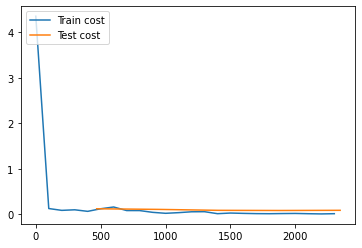

Best pass is 3, testing Avgcost is [0.08119078]
The classification accuracy is 97.66%


<Figure size 432x288 with 0 Axes>

In [12]:
lists = []
step = 0
for epoch_id in epochs:
    for step_id, data in enumerate(train_reader()):  # iterate through the data
        # train
        metrics = exe.run(main_program,
                          feed=feeder.feed(data),  # create the dict data
                          fetch_list=[avg_loss, acc])
        
        if step % 100 == 0:  # print the log every 100 time
            event_handler_plot(train_prompt, step, metrics[0])  # plot
        step += 1

    
    # test the effect of each epoch (validate the data)
    for i,test_data in enumerate(test_reader()):
        if i == 1:
            break
    avg_loss_val, acc_val = exe.run(test_program,
                                   feed = feeder.feed(test_data),
                                   fetch_list= [avg_loss,acc])
    event_handler_plot(test_prompt, step, avg_loss_val[0])
    
    # save the result
    lists.append((epoch_id, avg_loss_val, acc_val))
    
    # save the model for prediction
    if save_dirname is not None:
        fluid.io.save_inference_model(save_dirname,
                                      ["img"],  # the varname of the feeded data
                                      [prediction],  # predicted values
                                      exe)  #executor containing the whole network

# choose the best one
best = sorted(lists, key=lambda list: float(list[1]))[0]
print('Best pass is %s, testing Avgcost is %s' % (best[0], best[1]))
print('The classification accuracy is %.2f%%' % (float(best[2]) * 100))

## Application

In [13]:
def load_image(file):
    im = Image.open(file).convert('L')
    im = im.resize((28, 28), Image.ANTIALIAS)
    # convert image into array
    im = numpy.array(im).reshape(1, 1, 28, 28).astype(numpy.float32)
    # normalization
    im = im/255 * -2 + 1

    return im

tensor_img = load_image('./imgs/9_1.bmp')

Inference result is: 9


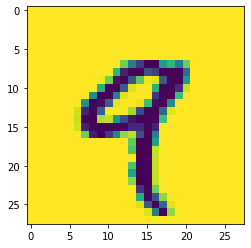

In [14]:
inference_scope = fluid.core.Scope()

with fluid.scope_guard(inference_scope):
    # use fluid.io.load_inference_model to get the inference program desc
    # feed_target_names: specify the variable names passed into the network
    # fetch_targets: specify the variable names fetched from the network
    [inference_program, feed_target_names, fetch_targets] = fluid.io.load_inference_model(save_dirname, exe, None, None)

    # construct the feed into dict: {feed_target_name: feed_target_data}
    # results will contain a list corresponding to the fetch_targets
    results = exe.run(inference_program,
                            feed={feed_target_names[0]: tensor_img},
                            fetch_list=fetch_targets)
    lab = numpy.argsort(results)

    # print the prediction
    img=Image.open('./imgs/9_1.bmp')
    plt.imshow(img)
    print("Inference result is: %d" % lab[0][0][-1])